In [1]:
import polars as pl
import numpy as np
import pickle
from typing import List
from itertools import chain, combinations
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLMResults
from statsmodels.genmod.families import family

In [3]:
import graphviz
import networkx as nx
from cdt.data import AcyclicGraphGenerator
import scipy

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [122]:
from scipy import stats
from pycit import citest
from pgmpy.estimators import CITests
from tqdm import tqdm

In [5]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from collections import OrderedDict

In [449]:
class TestingRound:
    iterations = 0
    last_deviance = None
    deviance = 0
    convergence_threshold = 1e-8
    rss = None
    llf = None
    total_samples = None
    
    def __init__(self, y_label, X_labels):
        self.y_label = y_label
        self.X_labels = X_labels
        self._init_beta0()
        self.client_data = {
            'xtx': [],
            'xtz': [],
            'dev': [],
            'llf': [],
            'rss': [],
            'nobs': []
            }
        
    def __eq__(self, t):
        assert type(t) == TestingRound
        return self.y_label == t.y_label and self.X_labels == t.X_labels   
    
    def __repr__(self):
        return f'TestingRound - y: {self.y_label}, X: {self.X_labels}, total samples: {self.total_samples}, beta: {self.beta}, current iteration: {self.iterations}, current deviance: {abs(self.deviance)}, relative deviance change: {abs(self.deviance - self.last_deviance) / (0.1 + abs(self.deviance)) if self.last_deviance is not None else "?"}, llf: {self.llf}, rss: {self.rss}' 
    
    def _init_beta0(self):
        #self.beta = np.random.randn(len(self.X_labels) + 1) # +1 for intercept
        self.beta = np.zeros(len(self.X_labels) + 1) # +1 for intercept
        
    def get_relative_change_in_deviance(self):
        if self.last_deviance is None:
            return None
        return abs(self.deviance - self.last_deviance) / (0.1 + abs(self.deviance))
    
    def get_fit_stats(self, client_subset=None):
        #dev = [v for k,v in self.client_data['dev'].items() if client_subset is None or k in client_subset]
        llf = [v for k,v in self.client_data['llf'].items() if client_subset is None or k in client_subset]
        rss = [v for k,v in self.client_data['rss'].items() if client_subset is None or k in client_subset]
        nobs = [v for k,v in self.client_data['nobs'].items() if client_subset is None or k in client_subset]
    
        return {'llf': sum(llf), 'rss': sum(rss), 'nobs': sum(nobs)}
        
    def aggregate_results(self, results):
        self.providing_clients = set(results.keys())
        
        client_data = [[(k,vi) for vi in v] for k,v in results.items()]
        xtx, xtz, dev, llf, rss, nobs = zip(*client_data)
        xtx, xtz, dev, llf, rss, nobs = dict(xtx), dict(xtz), dict(dev), dict(llf), dict(rss), dict(nobs)
        
        self.client_data['xtx'] = xtx
        self.client_data['xtz'] = xtz
        self.client_data['dev'] = dev
        self.client_data['llf'] = llf
        self.client_data['rss'] = rss
        self.client_data['nobs'] = nobs
        
        self.beta = np.linalg.inv(sum(xtx.values())) @ sum(xtz.values())
        self.last_deviance = self.deviance
        self.deviance = sum(dev.values())
        self.llf = sum(llf.values())
        self.rss = sum(rss.values())
        self.total_samples = sum(nobs.values())
        self.iterations += 1
        
        return self.get_relative_change_in_deviance() < self.convergence_threshold
    
class TestingEngine:
    def __init__(self, available_data, max_regressors=None, max_iterations=25, save_steps=10):
        self.available_data = available_data
        self.max_regressors = max_regressors
        self.max_iterations = max_iterations
        self.save_steps = save_steps
        
        self.finished_rounds = []
        self.testing_rounds = []
        
        _max_conditioning_set_size = min(len(self.available_data)-1, self.max_regressors) if self.max_regressors is not None else len(self.available_data)-1
        
        # for y_var in available_data:
        #     set_of_regressors = available_data - {y_var}
        #     powerset_of_regressors = chain.from_iterable(combinations(set_of_regressors, r) for r in range(0,_max_conditioning_set_size+1))
        #     self.testing_rounds.extend([TestingRound(y_label=y_var, X_labels=sorted(list(x_vars))) for x_vars in powerset_of_regressors])
        self.testing_rounds.extend([TestingRound(y_label='X', X_labels=['Y']),
                                    TestingRound(y_label='X', X_labels=['Y', 'Z']),
                                    TestingRound(y_label='X', X_labels=['Z']),
                                    ])
            
        self.testing_rounds = sorted(self.testing_rounds, key=lambda key: len(key.X_labels))
        self.is_finished = len(self.testing_rounds) == 0
            
    def get_current_test_parameters(self):
        curr_testing_round = self.testing_rounds[0]
        return curr_testing_round.y_label, curr_testing_round.X_labels, curr_testing_round.beta
    
    def remove_current_test(self):
        self.testing_rounds.pop(0)
        self.is_finished = len(self.testing_rounds) == 0
    
    def finish_current_test(self):
        self.finished_rounds.append(self.testing_rounds.pop(0))
        self.is_finished = len(self.testing_rounds) == 0
        
    def aggregate_results(self, results):
        has_converged = self.testing_rounds[0].aggregate_results(results)
        has_reached_max_iterations = self.testing_rounds[0].iterations >= self.max_iterations
        if has_converged or has_reached_max_iterations:
            self.finish_current_test()
        

class Server:
    def __init__(self, clients, max_regressors=None):
        self.clients = clients
        self.available_data = set.union(*[set(c.data_labels) for c in self.clients.values()])
        self.testing_engine = TestingEngine(self.available_data, max_regressors=max_regressors)
        
    def run_tests(self):
        counter = 1
        while not self.testing_engine.is_finished:
            y_label, X_labels, beta = self.testing_engine.get_current_test_parameters()
            selected_clients = {id_: c for id_, c in self.clients.items() if set([y_label] + X_labels).issubset(c.data_labels)}
            if len(selected_clients) == 0:
                self.testing_engine.remove_current_test()
                continue
            # http response, to compute glm results for y regressed on X with beta
            results = {id:c.compute(y_label, X_labels, beta) for id_,c in selected_clients.items()}
            self.testing_engine.aggregate_results(results)
            if counter % self.testing_engine.save_steps == 0:
                counter = 0
                with open('./testengine.ckp', 'wb') as f:
                    pickle.dump(self.testing_engine, f)
            counter += 1
                
    
class Client:
    def __init__(self, data):
        self.data_labels = sorted(data.columns)
        self.data = data[self.data_labels]
        
    def compute(self, y_label: str, X_labels: List[str], beta):
        y = self.data[y_label]
        X = self.data[X_labels]
        
        print(f'Computing {y_label} ~ {X_labels}')
        print(X.head(1))
        
        X = X.to_numpy()
        X = sm.tools.add_constant(X)
                
        eta, mu, dmu_deta, deviance, llf, rss = self._init_compute(y,X,beta)
        
        z = eta + (y - mu)/dmu_deta
        W = np.diag((dmu_deta**2)/max(np.var(mu), 1e-8))
        
        r1 = X.T @ W @ X
        r2 = X.T @ W @ z
        
        return r1, r2, deviance, llf, rss, len(y)
        
        
    def _init_compute(self, y, X, beta):
        glm_model = sm.GLM(y, X, family=family.Gaussian())
        normalized_cov_params = np.linalg.inv(X.T.dot(X))
        glm_results = GLMResults(glm_model, beta, normalized_cov_params=normalized_cov_params, scale=None)
        
        eta = glm_results.predict(which='linear')
        
        # g' is inverse of link function
        inverse_link = glm_results.family.link.inverse
        mu = inverse_link(eta)
        
        deviance = glm_results.deviance
        
        # delta g' is derivative of inverse link function
        derivative_inverse_link = glm_results.family.link.inverse_deriv
        dmu_deta = derivative_inverse_link(eta)
        
        rss = sum(glm_results.resid_response**2)
    
        return eta, mu, dmu_deta, deviance, glm_results.llf, rss

In [395]:
class LikelihoodRatioTest:
    def __init__(self, t0: TestingRound, t1: TestingRound) -> None:
        
        assert t0.y_label == t1.y_label
        self.t0 = t0
        self.t1 = t1
        
        self.y_label = self.t0.y_label
        
        if len(t0.X_labels) == 0 and len(t1.X_labels) == 1:
            self.x_label = self.t1.X_labels[0]
            self.s_labels = []
        else:
            assert len(t0.X_labels) == 1
            assert len(t1.X_labels) > 1
            assert t0.X_labels[0] in t1.X_labels
            
            self.x_label = self.t0.X_labels[0]
            self.s_labels = sorted(list(set(self.t1.X_labels) - {self.x_label}))
            #self.s_labels = self.t1.X_labels
            #self.s_labels.remove(self.x_label)
            
        print(f"{t0}\n{t1}\n{'-'*20}\n{self.y_label, self.x_label, self.s_labels}")
        
        #self.p_val = round(self._run_likelihood_test(),4)
        self.p_val = round(self._run_f_test(),4)
        
    def __repr__(self):
        return f"LikelihoodRatioTest - y: {self.y_label}, x: {self.x_label}, S: {self.s_labels}, p: {self.p_val}"
    
    def _run_likelihood_test(self):
        
        # t1 should always encompass more regressors -> less client can fulfill this
        #assert len(self.t1.providing_clients) < len(self.t0.providing_clients)
        
        t0_fit_stats = self.t0.get_fit_stats(self.t1.providing_clients)
        t1_fit_stats = self.t1.get_fit_stats(self.t1.providing_clients)
        
        #assert t0_fit_stats['nobs'] == t1_fit_stats['nobs']
        
        t = -2*(t0_fit_stats['llf'] - t1_fit_stats['llf'])
        
        par0 = len(self.t0.X_labels) + 1 # + intercept
        par1 = len(self.t1.X_labels) + 1 # + intercept
        
        p_val = scipy.stats.chi2.sf(t, par1-par0)
        
        return p_val
        
    def _run_f_test(self):
        # t1 should always encompass more regressors -> less client can fulfill this
        #assert len(self.t1.providing_clients) < len(self.t0.providing_clients)
        
        t0_fit_stats = self.t0.get_fit_stats(self.t1.providing_clients)
        t1_fit_stats = self.t1.get_fit_stats(self.t1.providing_clients)
        
        rss0 = t0_fit_stats['rss']
        rss1 = t1_fit_stats['rss']
        par0 = len(self.t0.X_labels) + 1 # X + intercept
        par1 = len(self.t1.X_labels) + 1 # X + intercept
        nobs = t0_fit_stats['nobs']
        delta_rss = rss0 - rss1
        dfn = par1 - par0
        dfd = nobs - par1
        
        f = delta_rss*dfd/rss1/dfn
        
        p_val = scipy.stats.f.sf(f, dfn, dfd)
        
        return p_val

In [396]:
class SymmetricLikelihoodRatioTest:
    
    def __init__(self, lrt0: LikelihoodRatioTest, lrt1: LikelihoodRatioTest):
        
        assert lrt0.y_label == lrt1.x_label or lrt1.x_label is None
        assert lrt1.y_label == lrt0.x_label or lrt0.x_label is None
        
        
        #print(lrt0.s_labels, lrt1.s_labels)
        assert lrt0.s_labels.sort() == lrt1.s_labels.sort()
        
        self.label1 = lrt0.y_label
        self.label2 = lrt1.y_label
        self.conditioning_set = lrt0.s_labels
        
        self.lrt0: LikelihoodRatioTest = lrt0
        self.lrt1: LikelihoodRatioTest = lrt1
        
        self.p_val = min(2*min(self.lrt0.p_val, self.lrt1.p_val), max(self.lrt0.p_val, self.lrt1.p_val))
        
    def __repr__(self):
        #return f"SymmetricLikelihoodRatioTest - v0: {self.label1}, v1: {self.label2}, conditioning set: {self.conditioning_set}"
        return f"SymmetricLikelihoodRatioTest - v0: {self.label1}, v1: {self.label2}, conditioning set: {self.conditioning_set}, p: {self.p_val}\n\t-{self.lrt0}\n\t-{self.lrt1}"

## Linear Model Results to Likelihood Ratio Tests

In [216]:
def get_likelihood_tests(finished_rounds):
    null_models = [r for r in finished_rounds if len(r.X_labels) == 0]
    base_models = [r for r in finished_rounds if len(r.X_labels) == 1]
    conditioned_models = [r for r in finished_rounds if len(r.X_labels) > 1]
    
    tests = []
    
    for bm in base_models:
        nm = [m for m in null_models if m.y_label == bm.y_label]
        if len(nm) == 0:
            continue
        assert len(nm) == 1, 'Too many hits for null model'
        nm = nm[0]
        
        lrt = LikelihoodRatioTest(nm, bm)
        tests.append(lrt)
    for cm in conditioned_models:
        bms = [m for m in base_models if m.y_label == cm.y_label and m.X_labels[0] in cm.X_labels]
        for bm in bms:
            lrt = LikelihoodRatioTest(bm, cm)
            tests.append(lrt)
    return tests

In [248]:
def get_symmetric_likelihood_tests(finished_rounds):

    # TODO: verfiy correctness

    ### OBTAIN CORRECT TESTING ROUNDS FOR LIKELIHOOD RATIO TESTS
    null_models = {}
    base_models = {}
    conditioned_models = defaultdict(list)

    for round in finished_rounds:
        if len(round.X_labels) == 0:
            null_models[round.y_label] = round
        elif len(round.X_labels) == 1:
            base_models[(round.y_label, round.X_labels[0])] = round
        else:
            for x_var in round.X_labels:
                conditioned_models[(round.y_label, x_var)].append(round)
                      
    #len(null_models), len(base_models), len(conditioned_models)
    
    ### GENERATE LIKELIHOOD RATIO TESTS
    likelihood_ratio_tests = []
    unique_combinations = [k for k in conditioned_models.keys() if k[0] < k[1]]

    for v0, v1 in unique_combinations:
        base_test0 = base_models[(v0,v1)]
        base_test1 = base_models[(v1,v0)]
        # null test
        lrt0 = LikelihoodRatioTest(null_models[v0], base_test0)
        lrt1 = LikelihoodRatioTest(null_models[v1], base_test1)
        likelihood_ratio_tests.append(SymmetricLikelihoodRatioTest(lrt0, lrt1))
        
        cond_tests0 = conditioned_models[(v0, v1)]
        cond_tests1 = conditioned_models[(v1, v0)]
        
        lrts0 = [LikelihoodRatioTest(base_test0, t) for t in cond_tests0]
        lrts1 = [LikelihoodRatioTest(base_test1, t) for t in cond_tests1]
        
        likelihood_ratio_tests.extend([SymmetricLikelihoodRatioTest(l0, l1) for l0, l1 in zip(lrts0, lrts1)])
        
    return likelihood_ratio_tests

# DGP Helpers (SEM)

In [10]:
class Variable:
    def __init__(self, name, parents, influence, intercept, error_mean, error_var):
        self.name = name
        self.parents = parents
        self.influence = influence
        self.intercept = intercept
        self.error_mean = error_mean
        self.error_var = error_var
        
        self.value = None
        
    def get(self):
        if self.value is None:
            self.value = self._calc()
        return self.value
    
    def reset(self):
        self.value = None
        for p in self.parents:
            p.reset()
        
    def _calc(self):
        val = self.intercept
        for parent, coeff in zip(self.parents, self.influence):
            val += parent.get()*coeff
        val += np.random.normal(self.error_mean,self.error_var)
            
        return val

In [11]:
def toposort(variables):
    sorted_list = []
    no_inc_edge_nodes = {v for v in variables if len(v.parents) == 0}
    graph = {v:set(v.parents) for v in variables if len(v.parents) > 0}
    
    while len(no_inc_edge_nodes) > 0:
        node = no_inc_edge_nodes.pop()
        sorted_list.append(node)
        for node_i in [v for v,ps in graph.items() if node in ps]:
            graph[node_i].remove(node)
            if len(graph[node_i]) == 0:
                no_inc_edge_nodes.add(node_i)
                
    return sorted_list

## Visualization

In [12]:
arrow_type_lookup = {
        1: 'odot',
        2: 'normal',
        3: 'none'
    }
def data2graph(data, labels):
    graph = graphviz.Digraph(format='png')
    for i in range(len(data)):
        for j in range(i+1,len(data)):
            arrhead = data[i][j]
            arrtail = data[j][i]
            if data[i][j] == 1:
                graph.edge(labels[i], labels[j], arrowtail=arrow_type_lookup[arrtail], arrowhead=arrow_type_lookup[arrhead])
            elif data[i][j] == 2:
                graph.edge(labels[i], labels[j], arrowtail=arrow_type_lookup[arrtail], arrowhead=arrow_type_lookup[arrhead])
            elif data[i][j] == 3:
                graph.edge(labels[i], labels[j], arrowtail=arrow_type_lookup[arrtail], arrowhead=arrow_type_lookup[arrhead])
            else:
                # just insert the nodes if there is no edge between them
                graph.node(labels[i], labels[i])
                graph.node(labels[j], labels[j])
    return graph

## Test Results to Dataframe Conversion

In [13]:
def lrt2pandas(lrts: List[SymmetricLikelihoodRatioTest], label2id_mapping):
    data = []
    for lrt in lrts:
        d = {}
        d['ord'] = len(lrt.conditioning_set)
        if lrt.label1 < lrt.label2:
            d['X'] = str(label2id_mapping[lrt.label1])
            d['Y'] = str(label2id_mapping[lrt.label2])
        else:
            d['X'] = str(label2id_mapping[lrt.label2])
            d['Y'] = str(label2id_mapping[lrt.label1])
        d['S'] = ','.join([str(label2id_mapping[l]) for l in lrt.conditioning_set])
        #d['S'] = list([label2id_mapping[l] for l in lrt.conditioning_set])
        d['pvalue'] = lrt.p_val
        data.append(d)
    df = pl.from_dicts(data).unique().sort('ord', 'X', 'Y', 'S').to_pandas()
    df.index += 1
    df = df.astype({'ord': 'int32', 'X':'int32', 'Y':'int32'})
    df.index = [str(idx) for idx in df.index]
    return df 

## FCI

In [15]:
def run_local_fci(df, labels, alpha=0.05):
    with (ro.default_converter + pandas2ri.converter).context():
        ro.r['source']('../scripts/aggregation.r')
        aggregate_ci_results_f = ro.globalenv['aggregate_ci_results']
        
        d = [('citestResults', ro.conversion.get_conversion().py2rpy(df)), ('labels', ro.StrVector(labels))]
        od = OrderedDict(d)
        lv = ro.ListVector(od)

        result = aggregate_ci_results_f([lv], alpha)

        pag = [x[1].tolist() for x in result['G_PAG_List'].items()][0]
        pag_labels = [list(x[1]) for x in result['G_PAG_Label_List'].items()][0]
        
    return pag,pag_labels

## DGP

In [36]:
# generate: try rescale=False and rescale=True (default)

In [124]:
NUM_CLIENTS = 1
TOTAL_FEATURES = 3
FEATURES_PER_CLIENT = 3

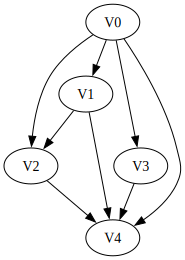

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


In [60]:
## DGP 1

generator = AcyclicGraphGenerator('linear', npoints=25000, nodes=TOTAL_FEATURES)
data, graph = generator.generate()
#generator.to_csv('generated_graph')

dag = graphviz.Source(nx.nx_agraph.to_agraph(graph).to_string())
# dag.render('target_graph')
display(dag)

# split data
data_splits = np.array_split(data, NUM_CLIENTS)

selected_data_splits = []
for data_split in data_splits:
    drop_cols = list(np.random.choice(data_split.columns, TOTAL_FEATURES-FEATURES_PER_CLIENT, replace=False))
    selected_data_splits.append(data_split.drop(drop_cols, axis=1))
data_splits = selected_data_splits
del selected_data_splits

clients = {i:Client(data_split) for i,data_split in enumerate(data_splits)}

In [450]:
# DGP 2

possible_dags = [
    "pdsep_g",
    "collider",
    "fork",
    "chain4",
    "descColl",
    "2descColl",
    "iv"
]


clients = {}


def get_sample_data(dag_type, num_clients, num_samples, num_vars):
    with (ro.default_converter + pandas2ri.converter).context():
        ro.r['source']('../scripts/example_data.r')
        get_example_data_f = ro.globalenv['get_example_data']

        result = get_example_data_f(dag_type, num_clients, num_samples, num_vars)
        
    return result

# TOTAL_FEATURES cant be set for this call right now, because the true graph is fixed
r = get_sample_data(possible_dags[2], NUM_CLIENTS, 10_000, FEATURES_PER_CLIENT)
for i,(_,v) in enumerate(r.items()):
    #v.to_csv(f'./test-data/data-{i}.csv')
    clients[i] = Client(v)
    
data = pl.concat([pl.from_pandas(c.data) for c in clients.values()], how='diagonal').to_pandas()

In [180]:
# DGP 3

# Setup

a = Variable('A', [], [], 2, 0, 1)
b = Variable('B', [], [], -3, 1, 1)
c = Variable('C', [a,b], [3,-1.5], 0, 1, 2)

variables = [a,c,b]
last_variable = toposort(variables)[-1]


# Generate

samples = []

num_samples = 9000
for i in range(num_samples):
    last_variable.get()
    sample = {v.name:v.get() for v in variables}
    samples.append(sample)
    last_variable.reset()
    
#samples = {k: [dic[k] for dic in samples] for k in samples[0]}
data = pl.from_dicts(samples).to_pandas()

# Seperate data to clients

data_splits = np.array_split(data, NUM_CLIENTS)

selected_data_splits = []
for data_split in data_splits:
    drop_cols = list(np.random.choice(data_split.columns, TOTAL_FEATURES-FEATURES_PER_CLIENT, replace=False))
    selected_data_splits.append(data_split.drop(drop_cols, axis=1))
data_splits = selected_data_splits
del selected_data_splits

clients = {i:Client(data_split) for i,data_split in enumerate(data_splits)}

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


## Server Run

In [ ]:
# Do not use FCI yet: Just test CI!
# -> Generated correlated data with a set of equations, e.g. y = alpha*x + beta*z
# linear equations with gaussian error, (cov mat needs to be pos def.)
#
# --- 
# logistic regression for binary variable
# ---
# check p value of other packages to my p value!!
#  - compute p value pooled and unpooled


# x ~ N(2,5) (may or may not be standard norm. dist.)


# STANDARDIZE DATASET!! (x-mean)/var


# y = beta0 + beta1*x + beta2*w + beta3*v + GAUSSIAN_ERROR
# y = f(z,w)
# x = g(z)

In [ ]:
# partial correlation test, scipy (gaussian)
# chi square test (multinomial)

In [ ]:
# Lookup simulation of binary data for logistic regression/categories for multinomial

In [ ]:
# For Paper:
# Dont rewrite paper -> Just quickly review/mention/explain the papers this is based on

# Explain Federated GLM
# Explained Symmetric CI Test
# Explain implementation

# Focus on two points, 1. federated CI, 2. client server architecture to run tests with others

In [451]:
server = Server(clients, max_regressors=None)

In [452]:
server.run_tests()

Computing X ~ ['Y']
          Y
1 -0.038854
Computing X ~ ['Y']
          Y
1 -0.038854
Computing X ~ ['Y']
          Y
1 -0.038854
Computing X ~ ['Z']
          Z
1  0.972423
Computing X ~ ['Z']
          Z
1  0.972423
Computing X ~ ['Z']
          Z
1  0.972423
Computing X ~ ['Y', 'Z']
          Y         Z
1 -0.038854  0.972423
Computing X ~ ['Y', 'Z']
          Y         Z
1 -0.038854  0.972423
Computing X ~ ['Y', 'Z']
          Y         Z
1 -0.038854  0.972423


In [279]:
likelihood_ratio_tests = get_symmetric_likelihood_tests(server.testing_engine.finished_rounds)
len(likelihood_ratio_tests)

6

In [454]:
likelihood_ratio_tests = get_likelihood_tests(server.testing_engine.finished_rounds)
len(likelihood_ratio_tests)

TestingRound - y: X, X: ['Y'], total samples: 10000, beta: [-0.00682777  0.05292265], current iteration: 3, current deviance: 9962.184372689702, relative deviance change: 0.0, llf: -14170.441677464849, rss: 9962.18437268967
TestingRound - y: X, X: ['Y', 'Z'], total samples: 10000, beta: [-0.00497337 -0.00778686  0.12348866], current iteration: 3, current deviance: 9846.489477363455, relative deviance change: 0.0, llf: -14112.034834185693, rss: 9846.489477363477
--------------------
('X', 'Y', ['Z'])
TestingRound - y: X, X: ['Z'], total samples: 10000, beta: [-0.00513483  0.11965614], current iteration: 3, current deviance: 9846.950028968095, relative deviance change: 0.0, llf: -14112.268694606355, rss: 9846.95002896808
TestingRound - y: X, X: ['Y', 'Z'], total samples: 10000, beta: [-0.00497337 -0.00778686  0.12348866], current iteration: 3, current deviance: 9846.489477363455, relative deviance change: 0.0, llf: -14112.034834185693, rss: 9846.489477363477
--------------------
('X', 'Z

2

In [467]:
server.testing_engine.finished_rounds

[TestingRound - y: X, X: ['Y'], total samples: 10000, beta: [-0.00682777  0.05292265], current iteration: 3, current deviance: 9962.184372689702, relative deviance change: 0.0, llf: -14170.441677464849, rss: 9962.18437268967,
 TestingRound - y: X, X: ['Z'], total samples: 10000, beta: [-0.00513483  0.11965614], current iteration: 3, current deviance: 9846.950028968095, relative deviance change: 0.0, llf: -14112.268694606355, rss: 9846.95002896808,
 TestingRound - y: X, X: ['Y', 'Z'], total samples: 10000, beta: [-0.00497337 -0.00778686  0.12348866], current iteration: 3, current deviance: 9846.489477363455, relative deviance change: 0.0, llf: -14112.034834185693, rss: 9846.489477363477]

In [474]:
def _init_compute(y, X, beta):
    glm_model = sm.GLM(y, X, family=family.Gaussian())
    #normalized_cov_params = np.linalg.inv(X.T.dot(X))
    #glm_results = GLMResults(glm_model, beta, normalized_cov_params=normalized_cov_params, scale=None)
    glm_results = glm_model.fit()
    
    eta = glm_results.predict(which='linear')
    
    # g' is inverse of link function
    inverse_link = glm_results.family.link.inverse
    mu = inverse_link(eta)
    
    deviance = glm_results.deviance
    
    # delta g' is derivative of inverse link function
    derivative_inverse_link = glm_results.family.link.inverse_deriv
    dmu_deta = derivative_inverse_link(eta)
    
    rss = sum(glm_results.resid_response**2)

    return eta, mu, dmu_deta, deviance, glm_results.llf, rss

def compute(data, y_label: str, X_labels: List[str], beta):
    y = data[y_label]
    X = data[X_labels]
    
    print(f'Computing {y_label} ~ {X_labels}')
    print(X.head(1))
    
    X = X.to_numpy()
    X = sm.tools.add_constant(X)
            
    eta, mu, dmu_deta, deviance, llf, rss = _init_compute(y,X,beta)
    
    z = eta + (y - mu)/dmu_deta
    W = np.diag((dmu_deta**2)/max(np.var(mu), 1e-8))
    
    r1 = X.T @ W @ X
    r2 = X.T @ W @ z
    
    return r1, r2, deviance, llf, rss, len(y)
        
        
t_x_y = compute(data, 'X', ['Y'], None)
t_x_z = compute(data, 'X', ['Z'], None)
t_x_yz = compute(data, 'X', ['Y', 'Z'], None)


Computing X ~ ['Y']
          Y
0 -0.038854
Computing X ~ ['Z']
          Z
0  0.972423
Computing X ~ ['Y', 'Z']
          Y         Z
0 -0.038854  0.972423


In [482]:
rss0 = t_x_z[-2]
rss1 = t_x_yz[-2]

print(rss0, rss1)

par0 = 1 + 1 # X + intercept
par1 = 2 + 1 # X + intercept
nobs = len(data)
delta_rss = rss0 - rss1
dfn = par1 - par0
dfd = nobs - par1

f = delta_rss*dfd/rss1/dfn

print('f',f)

p_val = scipy.stats.f.sf(f, dfn, dfd)
p_val

9846.950028968078 9846.489477363477
f 0.4675914600613368


0.49411315034053493

In [483]:
rss0 = t_x_y[-2]
rss1 = t_x_yz[-2]

print(rss0, rss1)

par0 = 1 + 1 # X + intercept
par1 = 2 + 1 # X + intercept
nobs = len(data)
delta_rss = rss0 - rss1
dfn = par1 - par0
dfd = nobs - par1

f = delta_rss*dfd/rss1/dfn

print('f',f)

p_val = scipy.stats.f.sf(f, dfn, dfd)
p_val

9962.18437268967 9846.489477363477
f 117.46337323925549


3.219092988893084e-27

In [435]:
t0_fit_stats = t0.get_fit_stats(t1.providing_clients)
t1_fit_stats = t1.get_fit_stats(t1.providing_clients)

rss0 = t0_fit_stats['rss']
rss1 = t1_fit_stats['rss']

print(rss0, rss1)

par0 = len(t0.X_labels) + 1 # X + intercept
par1 = len(t1.X_labels) + 1 # X + intercept
nobs = t0_fit_stats['nobs']
delta_rss = rss0 - rss1
dfn = par1 - par0
dfd = nobs - par1

f = delta_rss*dfd/rss1/dfn

print('f',f)

p_val = scipy.stats.f.sf(f, dfn, dfd)
p_val

6852.23200399929 6851.675463552414
f 0.812025449398098


0.3675438108010485

In [ ]:
('X', 'Z', ('Y',), 0.1664, 0.0)
('Y', 'Z', ('X',), 0.1664, 0.0)

('Y', 'X', ('Z',), 0.0, 0.1664)
('X', 'Y', ('Z',), 0.0, 0.1664)

# TODO: WHY IS THIS SWITCHED IN MY IMPLEMENTATION?!

In [455]:
# Sanity check obtained p values
p_vals = [l.p_val for l in likelihood_ratio_tests]
min(p_vals), max(p_vals)

(0.0, 0.4941)

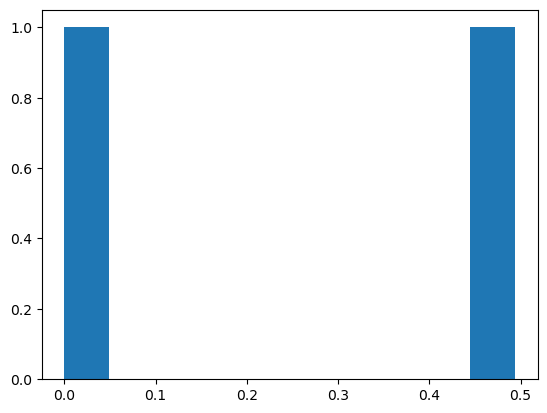

In [456]:
plt.hist(p_vals)
plt.show()

## CI Comparison

In [280]:
# ASYMMETRIC P_VALUES

asymmetric_likelihood_ratio_tests = [t.lrt0 for t in likelihood_ratio_tests] + [t.lrt1 for t in likelihood_ratio_tests]
possible_tests = set([(t.y_label, t.x_label, tuple(sorted(t.s_labels)), t.p_val) for t in asymmetric_likelihood_ratio_tests])
len(possible_tests)


12

In [193]:
# ONLY HAS SYMMETRIC P_VALUE

possible_tests = set([(t.label1, t.label2, tuple(sorted(t.conditioning_set)), t.p_val) for t in likelihood_ratio_tests])
len(possible_tests)

6

In [457]:
# FROM ASYMMETRIC TESTS

possible_tests = set([(t.y_label, t.x_label, tuple(sorted(t.s_labels)), t.p_val) for t in likelihood_ratio_tests])
len(possible_tests)

2

In [458]:
ci_comparisons = []

for test in tqdm(possible_tests):
    if len(test[2]) > 0:
        #v0 = data[test[0]].values
        #v1 = data[test[1]].values
        #s = data[list(test[2])].values
        #p0 = test[3]
        #p1 = citest(v0, v1, s, test_args={'statistic': 'ksg_cmi', 'n_jobs': 8})
        
        _, p1 = CITests.pearsonr(test[1], test[0], list(test[2]), data, boolean=False)
    else:
        v0 = data[test[0]]
        v1 = data[test[1]]
        correlation, p1 = stats.pearsonr(v0, v1)
        
    p1 = round(p1,4)
    
    ci_comparisons.append((*test, p1))

100%|██████████| 2/2 [00:00<00:00, 142.93it/s]


In [459]:
alpha = 0.05

counter = 0
count_approx_same_val = 0

for comp in ci_comparisons:
    if comp[3] == comp[4] or abs(1-(comp[3]/comp[4])) < 0.0001:
        count_approx_same_val += 1
    else:
        print(comp[3], comp[4])
        
    if (comp[3] < alpha and comp[4] < alpha) or (comp[3] > alpha and comp[4] > alpha):
        counter += 1
    else:
        print(comp)
        
print(f'% correct: {counter if counter==0 else counter/len(ci_comparisons):.2f}')
print(f'% same: {count_approx_same_val if count_approx_same_val==0 else count_approx_same_val/len(ci_comparisons):.2f}')

0.4941 0.0
('X', 'Z', ('Y',), 0.4941, 0.0)
0.0 0.4941
('X', 'Y', ('Z',), 0.0, 0.4941)
% correct: 0.00
% same: 0.00


divide by zero encountered in scalar divide


## FCI / Causal Discovery

In [181]:
label2id_mapping = {l:i for i,l in enumerate(sorted(server.available_data), start=1)}

df = lrt2pandas(likelihood_ratio_tests, label2id_mapping)
df

KeyError: 'D'

In [93]:
labels = [str(v) for v in label2id_mapping.keys()]

pag, pag_labels = run_local_fci(df, labels)

[1] "A" "B" "C" "D" "E"
[1] 5
Order=0; remaining edges:20
x= 1  y= 2  S=  : pval = 0.2945827 
x= 1  y= 3  S=  : pval = 7.665671e-39 
x= 1  y= 4  S=  : pval = 0.2783887 
x= 1  y= 5  S=  : pval = 3.327375e-05 
x= 2  y= 3  S=  : pval = 9.998619e-05 
x= 2  y= 4  S=  : pval = 0.3033387 
x= 2  y= 5  S=  : pval = 0.170096 
x= 3  y= 1  S=  : pval = 7.665671e-39 
x= 3  y= 2  S=  : pval = 9.998619e-05 
x= 3  y= 4  S=  : pval = 0.3593654 
x= 3  y= 5  S=  : pval = 1.792693e-66 
x= 4  y= 5  S=  : pval = 0.07930975 
x= 5  y= 1  S=  : pval = 3.327375e-05 
x= 5  y= 3  S=  : pval = 1.792693e-66 
Order=1; remaining edges:8
x= 1  y= 3  S= 5 : pval = 1.980302e-62 
x= 1  y= 5  S= 3 : pval = 1.980302e-62 
x= 3  y= 1  S= 2 : pval = 0.0003544918 
x= 3  y= 1  S= 5 : pval = 1.980302e-62 
x= 3  y= 2  S= 1 : pval = 2.637628e-38 
x= 3  y= 2  S= 5 : pval = 9.053535e-66 


x= 3  y= 5  S= 1 : pval = 8.665035e-35 
x= 3  y= 5  S= 2 : pval = 0.000533483 
x= 5  y= 1  S= 3 : pval = 1.980302e-62 
x= 5  y= 3  S= 1 : pval = 8.665035e-35 
Order=2; remaining edges:8
x= 3  y= 1  S= 2 5 : pval = 8.396653e-64 
x= 3  y= 2  S= 1 5 : pval = 2.047955e-97 
x= 3  y= 5  S= 1 2 : pval = 2.724267e-36 

Compute collider:

 1 *-> 3 <-* 2 

 2 *-> 3 <-* 1 

 2 *-> 3 <-* 5 

 5 *-> 3 <-* 2 

Possible D-Sep of 1 is: 2 3 5 

y =   3
.........
ord =  1 
ord =  2 

y =   5
.........
ord =  1 
x= 1  y= 5  S= 2 : pval = 0.3434701 

Possible D-Sep of 2 is: 1 3 5 

y =   3
.........
ord =  1 
ord =  2 

Possible D-Sep of 3 is: 1 2 5 

y =   1
.........

y =   2
.........

y =   5
.........

Possible D-Sep of 4 is:  

Possible D-Sep of 5 is: 1 2 3 

y =   3
.........
ord =  1 
ord =  2 
(1) Adding an arrowhead using dataset with variables  A,B,C,D,E 
(2) Adding an arrowhead using dataset with variables  A,B,C,D,E 
(1) Adding an arrowhead using dataset with variables  A,B,C,D,E 
(2) Adding

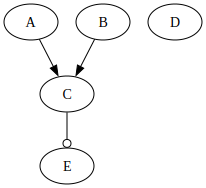

In [94]:
data2graph(pag, pag_labels)

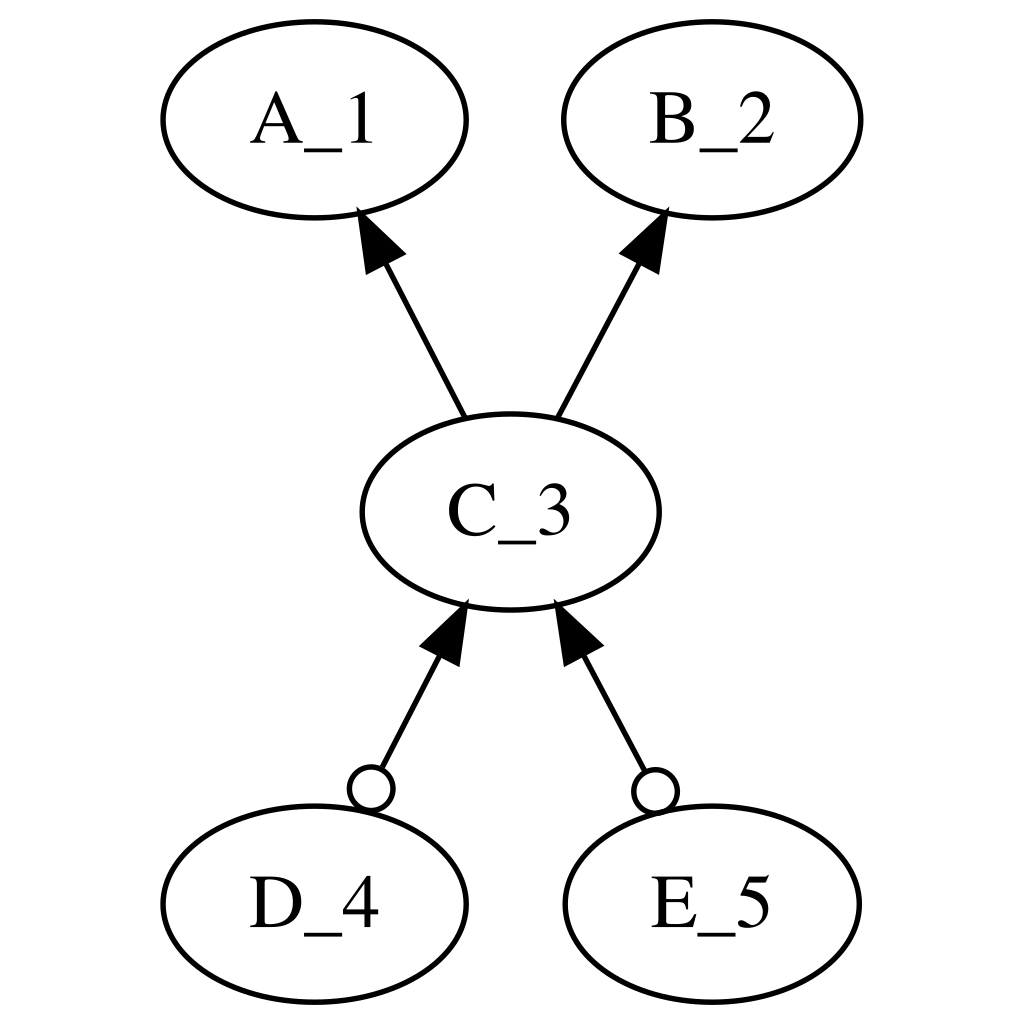

In [95]:
from IPython.display import display, Image
display(Image(filename='./tmp/ag.png'))

## Results

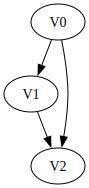

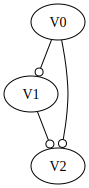

In [38]:
display(dag)
display(data2graph(pag, pag_labels))

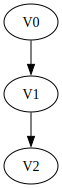

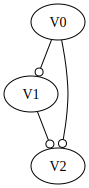

In [36]:
display(dag)
display(data2graph(pag, pag_labels))

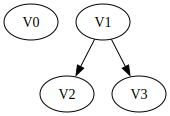

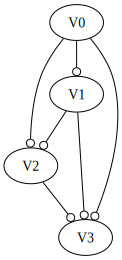

In [78]:
display(dag)
display(data2graph(pag, pag_labels))

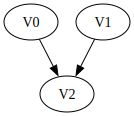

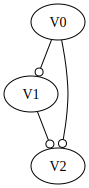

In [43]:
display(dag)
display(data2graph(pag, pag_labels))

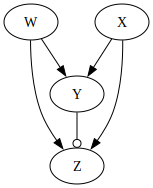

In [33]:
#display(dag)
# FROM example.r data
display(data2graph(pag, pag_labels))

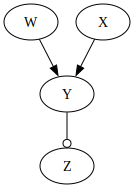

In [28]:
# attempt 2
data2graph(pag, pag_labels)